# Anomely Detection using Random Cut Forest

## Exploratory Data Analysis

In [84]:
# import libraries 
import pandas as pd 
import numpy as np
from datetime import datetime
import json 
import boto3
import botocore
import sagemaker
import sys

from sagemaker import RandomCutForest

import features_eng
import vis_lib

In [76]:

import boto3
import sagemaker 
sess = sagemaker.Session()

In [79]:
import importlib
import features_eng
importlib.reload(features_eng)

<module 'features_eng' from '/home/ec2-user/SageMaker/bsc-gameday/features_eng.py'>

In [77]:
# Initalize S3 for input and output 

bucket = (sagemaker.Session().default_bucket()) # s3://sagemaker-us-east-1-385320741566/
prefix = ""
execution_role = sagemaker.get_execution_role()
region = boto3.Session().region_name

# S3 bucket where the original data is downloaded and stored.
downloaded_data_bucket = "bsc-gameday-2024" # f"sagemaker-example-files-prod-{region}"
downloaded_data_prefix = "dataset"
model_metadata_prefix  = "modelmetadata"

def check_bucket_permission(bucket):
    # check if the bucket exists
    permission = False
    try:
        boto3.Session().client("s3").head_bucket(Bucket=bucket)
    except botocore.exceptions.ParamValidationError as e:
        print(
            "Hey! You either forgot to specify your S3 bucket"
            " or you gave your bucket an invalid name!"
        )
    except botocore.exceptions.ClientError as e:
        if e.response["Error"]["Code"] == "403":
            print(f"Hey! You don't have permission to access the bucket, {bucket}.")
        elif e.response["Error"]["Code"] == "404":
            print(f"Hey! Your bucket, {bucket}, doesn't exist!")
        else:
            raise
    else:
        permission = True
    return permission


if check_bucket_permission(bucket):
    print(f"Training input/output will be stored in: s3://{bucket}/{prefix}")
if check_bucket_permission(downloaded_data_bucket):
    print(
        f"Downloaded training data will be read from s3://{downloaded_data_bucket}/{downloaded_data_prefix}"
    )

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


Training input/output will be stored in: s3://sagemaker-us-east-1-385320741566/
Downloaded training data will be read from s3://bsc-gameday-2024/dataset


### Constants

In [5]:
DATA_FORMAT = "%m/%d/%Y %H:%M:%S"
FIG_SIZE = (40, 10)

Load data

In [6]:
# load data 
df = pd.read_csv("dataset/gameday.csv")

In [7]:
df.shape

(16804, 10)

In [8]:
df.head()

,log_identifier,timestamp,log_level,ip_address,user_id,method,path,status_code,response_time,message
0,LOG-000000,1.728414e+09,ERROR,205.92.167.221,51560a0e-a0f1-41d7-a70f-409b18e7881b,POST,posts/explore/search,400,1.782,Doctor color piece.
1,LOG-000001,1.728414e+09,WARN,219.119.1.141,329951fe-720d-4191-81c1-6632575f1140,GET,blog/app/blog,503,2.288,Need thank before help imagine young force his.
2,LOG-000002,1.728414e+09,ERROR,170.203.45.44,9e11c1d4-61f5-46c4-9837-5b10efd01662,PUT,posts/category/blog,403,2.077,Research less stage report provide put receive...
3,LOG-000003,1.728414e+09,INFO,204.125.12.235,19208bba-9ad9-4300-88da-1f6dd8d9da35,GET,main/explore/category,201,0.599,Including tax speak always last respond.
4,LOG-000000,1.728414e+09,ERROR,198.97.154.36,995b3a8b-cd1e-4f0f-9ba6-fe1532a80a6c,POST,main/blog,502,2.604,Sport agent here heart focus blue.


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16804 entries, 0 to 16803
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   log_identifier  16804 non-null  object 
 1   timestamp       16804 non-null  float64
 2   log_level       16804 non-null  object 
 3   ip_address      16804 non-null  object 
 4   user_id         16804 non-null  object 
 5   method          16804 non-null  object 
 6   path            16804 non-null  object 
 7   status_code     16804 non-null  int64  
 8   response_time   16804 non-null  float64
 9   message         16804 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 1.3+ MB


In [10]:
df[:1]

,log_identifier,timestamp,log_level,ip_address,user_id,method,path,status_code,response_time,message
0,LOG-000000,1.728414e+09,ERROR,205.92.167.221,51560a0e-a0f1-41d7-a70f-409b18e7881b,POST,posts/explore/search,400,1.782,Doctor color piece.


In [11]:
df.describe()

,timestamp,status_code,response_time
count,1.680400e+04,16804.000000,16804.000000
mean,1.728545e+09,390.506070,1.549394
std,7.533649e+04,110.250503,0.837462
min,1.728414e+09,200.000000,0.100000
25%,1.728479e+09,400.000000,0.823000
50%,1.728544e+09,403.000000,1.550000
75%,1.728610e+09,500.000000,2.275000
max,1.728676e+09,503.000000,3.000000


Categorical data unique values

In [12]:
object_cols = df.select_dtypes(include=["object", "category"]).columns
object_cols

Index(['log_identifier', 'log_level', 'ip_address', 'user_id', 'method',
       'path', 'message'],
      dtype='object')

In [13]:
unique_categorical_counts = df.select_dtypes(include=['object', 'category']).apply(lambda x:x.nunique())
unique_categorical_counts

log_identifier     9586
log_level             4
ip_address        16804
user_id           16804
method                4
path               1800
message           16804
dtype: int64

In [14]:
categorical_cols = ['log_level', 'method']

In [18]:
#df.head()

In [19]:
for col in categorical_cols: 
    print(f" ---------------- {col} ---------------- ")
    print(df[col].value_counts())

 ---------------- log_level ---------------- 
log_level
WARN     4255
ERROR    4202
INFO     4195
DEBUG    4152
Name: count, dtype: int64
 ---------------- method ---------------- 
method
GET       4305
POST      4194
DELETE    4176
PUT       4129
Name: count, dtype: int64


### Find the size of the time window based on which the data is collected

In [20]:
# Example timestamp as a string
timestamp_start = df["timestamp"].min()
timestamp_end = df["timestamp"].max()

print(f"start = {timestamp_start}, end = {timestamp_end}")

start = 1728413629.4160438, end = 1728675937.0076706


In [21]:
# Example timestamp as a string
timestamp_start = df["timestamp"].min()
timestamp_end = df["timestamp"].max()

def timestamp2date(timestamp_str):

    # Convert the string to a float
    timestamp_float = float(timestamp_str)

    # Convert the timestamp to a datetime object
    dt = datetime.fromtimestamp(timestamp_str)

    # Format the datetime object to the desired output format
    formatted_dt = dt.strftime(DATA_FORMAT)
    return formatted_dt

formatted_dts = timestamp2date(timestamp_start)
formatted_dte = timestamp2date(timestamp_end)

print(f"Start date = {formatted_dts} \nEnd date   = {formatted_dte}")


Start date = 10/08/2024 18:53:49 
End date   = 10/11/2024 19:45:37


In [22]:
df.log_level.value_counts()

log_level
WARN     4255
ERROR    4202
INFO     4195
DEBUG    4152
Name: count, dtype: int64

In [23]:
df.columns

Index(['log_identifier', 'timestamp', 'log_level', 'ip_address', 'user_id',
       'method', 'path', 'status_code', 'response_time', 'message'],
      dtype='object')

In [24]:
df.shape

(16804, 10)

## Data Visualizations

In [27]:
# Correlation
# df.corr()

 2 Sigma 3.25169455663703
 2 Sigma 3.223214929555942
 2 Sigma 3.202283175977367
 2 Sigma 3.2200747875061793


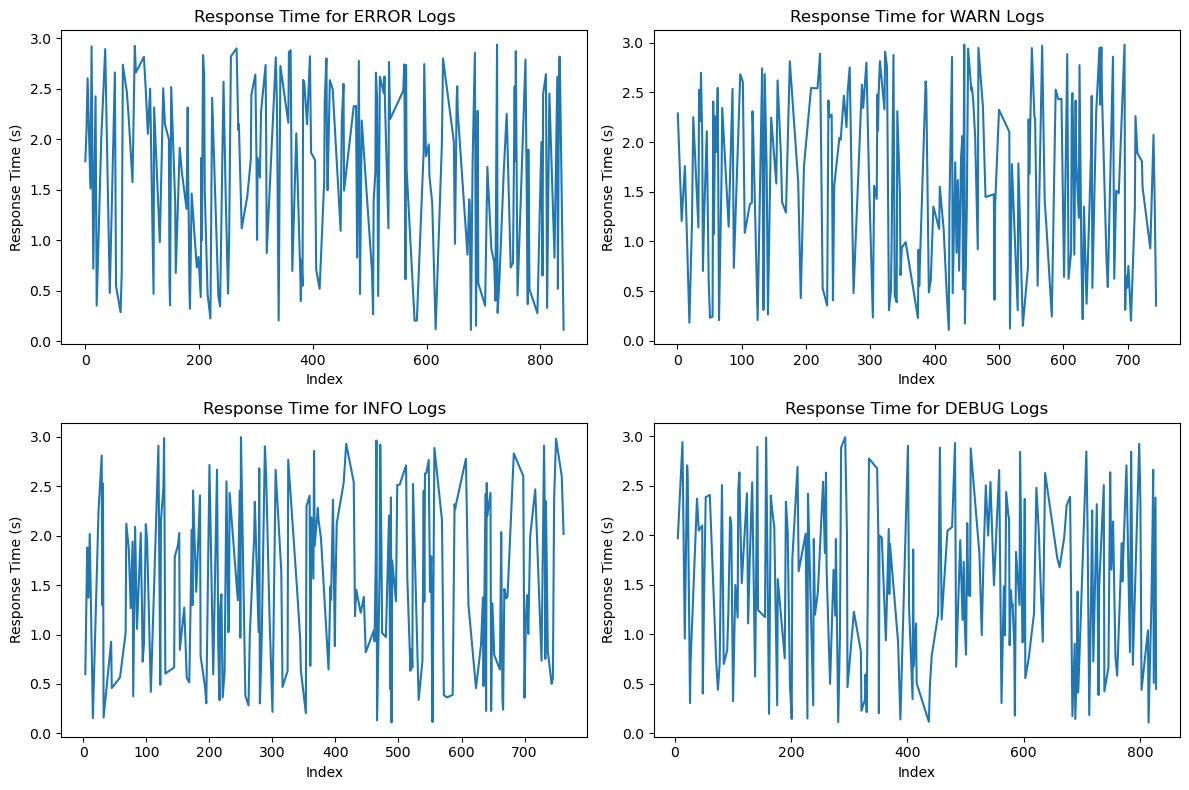

In [92]:
%matplotlib inline 

import matplotlib 
import matplotlib.pyplot as plt 

MaxNoRecords = 200
# Define figure size and number of subplots (2x2)
FIG_SIZE = (12, 8)
fig, axes = plt.subplots(2, 2, figsize=FIG_SIZE)

# Define the log levels to visualize
log_levels = ["ERROR", "WARN", "INFO", "DEBUG"]

# Define the y-value where the horizontal line should be drawn
#y_value = 1.5

# Iterate over the log levels and create a plot for each one
for i, log_level in enumerate(log_levels):
    row = i // 2  # Determine row index (0 or 1)
    col = i % 2   # Determine column index (0 or 1)
    
    condition = (df.log_level == log_level)
    sigma = df[condition]["response_time"].std()
    response_time_mean = df[condition]["response_time"].mean()
    sigma1 = response_time_mean + 1 * sigma 
    sigma2 = response_time_mean + 2 * sigma 
    sigma3 = response_time_mean + 3 * sigma 
    print(f" 2 Sigma {sigma2}")
    
    
    subset = df[condition]["response_time"][:MaxNoRecords]  # Select first 200 records with the log_level
    
    axes[row, col].plot(subset)
    axes[row, col].set_title(f"Response Time for {log_level} Logs")
    axes[row, col].set_xlabel("Index")
    axes[row, col].set_ylabel("Response Time (s)")
    
# Adjust layout for clarity
plt.tight_layout()

# Show the plot
plt.show()


 2 Sigma 3.2303540723153876
 2 Sigma 3.2267630059435226
 2 Sigma 3.215141331252283
 2 Sigma 3.225330550703233


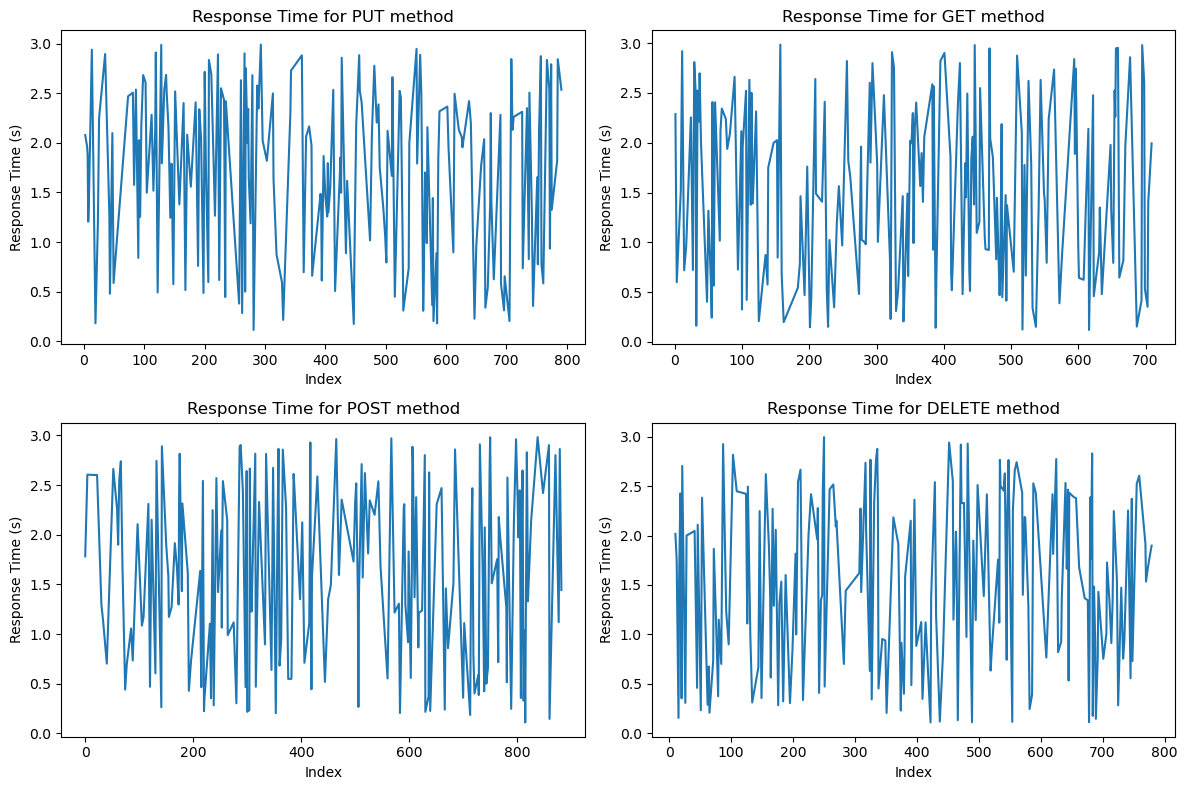

In [95]:
%matplotlib inline 

import matplotlib 
import matplotlib.pyplot as plt 

MaxNoRecords = 200
# Define figure size and number of subplots (2x2)
FIG_SIZE = (12, 8)
fig, axes = plt.subplots(2, 2, figsize=FIG_SIZE)

# Define the log levels to visualize
methods = ['PUT', 'GET', 'POST', 'DELETE']

# Define the y-value where the horizontal line should be drawn
#y_value = 1.5

# Iterate over the log levels and create a plot for each one
for i, method in enumerate(methods):
    row = i // 2  # Determine row index (0 or 1)
    col = i % 2   # Determine column index (0 or 1)
    
    condition = (df.method == method)
    sigma = df[condition]["response_time"].std()
    response_time_mean = df[condition]["response_time"].mean()
    sigma1 = response_time_mean + 1 * sigma 
    sigma2 = response_time_mean + 2 * sigma 
    sigma3 = response_time_mean + 3 * sigma 
    print(f" 2 Sigma {sigma2}")
    
    
    subset = df[condition]["response_time"][:MaxNoRecords]  # Select first 200 records with the log_level
    
    axes[row, col].plot(subset)
    axes[row, col].set_title(f"Response Time for {method} method")
    axes[row, col].set_xlabel("Index")
    axes[row, col].set_ylabel("Response Time (s)")
    
    
# Adjust layout for clarity
plt.tight_layout()

# Show the plot
plt.show()


<Axes: >

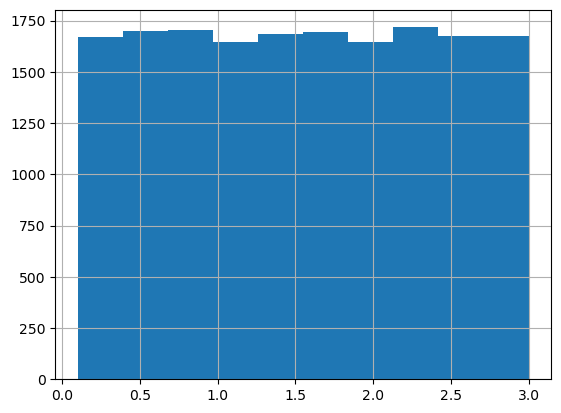

In [29]:
df["response_time"].hist()

The response time is relatively uniform distribution, as all bins show similar heights. This indicates that the response times in the dataset are spread fairly evenly across the different intervals.

1- No Significant Skew: no significant consentration on high or low response time.

2- Even distribution

3- No major outliers, if outliers were present, you would expect the distribution to be skewed to the right or left showing low number of high, or low values.

In [30]:
df.head(2)

,log_identifier,timestamp,log_level,ip_address,user_id,method,path,status_code,response_time,message
0,LOG-000000,1.728414e+09,ERROR,205.92.167.221,51560a0e-a0f1-41d7-a70f-409b18e7881b,POST,posts/explore/search,400,1.782,Doctor color piece.
1,LOG-000001,1.728414e+09,WARN,219.119.1.141,329951fe-720d-4191-81c1-6632575f1140,GET,blog/app/blog,503,2.288,Need thank before help imagine young force his.


In [31]:
df.status_code.value_counts()

status_code
403    1914
500    1913
401    1913
502    1898
200    1898
404    1844
400    1831
201    1821
503    1772
Name: count, dtype: int64

# Data Cleaning

### Remove Missing and Duplicate Records

1. Data Cleaning
Remove duplicates: Check for any duplicated log entries and remove them.
Handle missing values: drop rows for missing values to avoid bias in anomaly detection (instead of imputing the values)

In [32]:
df.shape[0]

16804

In [33]:
rncols = ['log_identifier', 'timestamp', 'log_level', 'ip_address', 'user_id', 'method', 'path', 'status_code', 'response_time']
features_eng.df_cleaning(df, columns=rncols, inplace=True)

In [34]:
df.columns

Index(['log_identifier', 'timestamp', 'log_level', 'ip_address', 'user_id',
       'method', 'path', 'status_code', 'response_time', 'message'],
      dtype='object')

# Feature Selection and Engineering

We need to capture the relevant features and the interactions between response time, log_level, method, and path. 

RCF operates on numerical data, so we need to transform categorical features such as log_level, method, and path into numerical values. Here’s what to consider:
- *Response Time (response_time):* <br> 
This is the main feature for anomaly detection. The higher the response time, the more likely it is to be anomalous. But we’ll also consider the context of other features.
- *Log Level (log_level):*  <br>
Different log levels (e.g., ERROR, WARN, INFO) could indicate the severity of issues in the logs, which may affect response time. Use ordinal encoding for this feature:
INFO: 0, DEBUG: 1, WARN: 2, ERROR: 3 (reflecting increasing severity).
- *Method (method):*  <br>
 HTTP methods (GET, POST, etc.) might influence response times differently. Use one-hot encoding or ordinal encoding if the order is important. For simplicity, we will use one-hot encoding:
E.g., GET = [1, 0, 0, 0], POST = [0, 1, 0, 0], etc.
- *Path (path):*  <br>
 Some paths may take longer to respond due to complexity, load, or other factors. Group and aggregate the paths, especially if there are many unique values. You can:
Use frequency encoding or count-based encoding to assign numeric values based on how frequently a path appears.<br>

For example, if the path /posts/explore/search appears frequently, it might have a higher weight.- 

### Time-Based Features 

Time-Based Data: Since log data has timestamps, we should also consider time-based features:<br>
- *Time of day or hour of the day:* <br>  Different times of day can affect response time. Extract this from the timestamp.<br>
Feature: Hour of the day (0–23).<br><br>
- *Day of the week:* <br>
Response times could vary based on the day (e.g., weekdays vs weekends).<br>
Feature: Day of the week (0–6).

### Data Standardization

RCF works better when features are on the same scale. <br>
When detecting outliers, it's recommended to use standardization techniques like Z-score scaling instead of Min-Max scaling. <br>Min-Max scaling normalizes values to a range between 0 and 1, which can compress normal values into a narrower range. This squashing effect makes it difficult for the model to effectively identify anomalies, as the extreme values may take the upper limit, obscuring the distinction between normal and anomalous data points.<br>
<br>
Centering the Data: <br> Z-score scaling centers the data around zero by subtracting the mean. This means that the distribution of values will have a mean of 0, allowing for easier comparison of deviations from the mean.
<br><br>
Z= (X−μ)/σ<br>
μ = mean<br>
σ = Standard diviation
​	
 

In [35]:
df.columns

Index(['log_identifier', 'timestamp', 'log_level', 'ip_address', 'user_id',
       'method', 'path', 'status_code', 'response_time', 'message'],
      dtype='object')

In [36]:
df.head(3)

,log_identifier,timestamp,log_level,ip_address,user_id,method,path,status_code,response_time,message
0,LOG-000000,1.728414e+09,ERROR,205.92.167.221,51560a0e-a0f1-41d7-a70f-409b18e7881b,POST,posts/explore/search,400,1.782,Doctor color piece.
1,LOG-000001,1.728414e+09,WARN,219.119.1.141,329951fe-720d-4191-81c1-6632575f1140,GET,blog/app/blog,503,2.288,Need thank before help imagine young force his.
2,LOG-000002,1.728414e+09,ERROR,170.203.45.44,9e11c1d4-61f5-46c4-9837-5b10efd01662,PUT,posts/category/blog,403,2.077,Research less stage report provide put receive...


In [39]:
prepared_data, prepared_df = features_eng.create_prepared_numpy_array(df)

# Display prepared data shape
print(prepared_data.shape)
prepared_data


(16804, 6)


array([[3.   , 0.   , 0.   , 1.   , 0.   , 1.782],
       [2.   , 0.   , 1.   , 0.   , 0.   , 2.288],
       [3.   , 0.   , 0.   , 0.   , 1.   , 2.077],
       ...,
       [3.   , 0.   , 0.   , 1.   , 0.   , 1.394],
       [1.   , 0.   , 0.   , 1.   , 0.   , 2.226],
       [2.   , 0.   , 0.   , 1.   , 0.   , 1.057]])

In [40]:
prepared_df.head()

,log_level,PUT,GET,POST,DELETE,response_time
0,3.0,0.0,0.0,1.0,0.0,1.782
1,2.0,0.0,1.0,0.0,0.0,2.288
2,3.0,0.0,0.0,0.0,1.0,2.077
3,1.0,0.0,1.0,0.0,0.0,0.599
4,3.0,0.0,0.0,1.0,0.0,2.604


# Training!!

In [41]:
# Split
split_index = int(len(prepared_data) * 0.8)  # 80% for training

X_train = prepared_data[:split_index]  # First 80% of the data
X_test = prepared_data[split_index:]     # Last 20% of the data


In [42]:
# Split index based on the length of prepared_data
split_index = int(len(prepared_data) * 0.8)  # 80% for training

# Split the original DataFrame based on the same index
train_df = df.iloc[:split_index]  # First 80% of the rows
test_df = df.iloc[split_index:]  # Remaining 20% of the rows
print(train_df.shape)
print(test_df.shape)

(13443, 10)
(3361, 10)


In [43]:
X_train.shape , X_test.shape

((13443, 6), (3361, 6))

In [44]:
print(f"s3://{bucket}{prefix}/output")
print(bucket)
print(prefix)

s3://sagemaker-us-east-1-385320741566/output
sagemaker-us-east-1-385320741566



In [45]:
session = sagemaker.Session()

# specify general training job information
rcf = RandomCutForest(
    role=execution_role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    #data_location=f"s3://{bucket}/{prefix}/", # for training job input 
    output_path=f"s3://{bucket}{prefix}/output", # For training Job Output 
    num_samples_per_tree=512,
    num_trees=50,
)

In [46]:
rcf.fit(rcf.record_set(X_train))

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: randomcutforest-2024-10-15-20-12-33-371


2024-10-15 20:12:34 Starting - Starting the training job...
2024-10-15 20:12:50 Starting - Preparing the instances for training...
2024-10-15 20:13:21 Downloading - Downloading input data...
2024-10-15 20:13:52 Downloading - Downloading the training image......
2024-10-15 20:15:08 Training - Training image download completed. Training in progress....
2024-10-15 20:15:38 Uploading - Uploading generated training model.Docker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:495: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if cons['type'] is 'ineq':
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:743: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(self.X_min) is not 0:
[10/15/2

In [47]:
print(f"Training job name: {rcf.latest_training_job.job_name}")

Training job name: randomcutforest-2024-10-15-20-12-33-371


# Inference

### Deploy Infernece Endpoint

In [48]:
rcf_inference = rcf.deploy(initial_instance_count=1, instance_type="ml.m5.xlarge")

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating model with name: randomcutforest-2024-10-15-20-16-20-741
INFO:sagemaker:Creating endpoint-config with name randomcutforest-2024-10-15-20-16-20-741
INFO:sagemaker:Creating endpoint with name randomcutforest-2024-10-15-20-16-20-741


-------!

In [49]:
print(f"Endpoint name: {rcf_inference.endpoint}")

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Endpoint name: randomcutforest-2024-10-15-20-16-20-741


In [50]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

rcf_inference.serializer = CSVSerializer()
rcf_inference.deserializer = JSONDeserializer()

results = rcf_inference.predict(X_test)

In [51]:
len(results['scores'])

3361

### Calculate the Threshold and Append Score to the DataFrame

In [81]:
# s into a python list 
scores = [datum["score"] for datum in results["scores"]]
# # threshold, score_mean, score_std = features_eng.calc_threshold(scores)
# threshold1, threshold2, threshold3 = calc_threshold(scores)
# threshold1, threshold2, threshold3
threshold, score_mean, score_std = features_eng.calc_threshold(scores)
threshold, score_mean, score_std

(1.1493371441080606, 0.8950671694090152, 0.08475665823301512)

## Store mean, sd, and 3sigma in a file 

In [86]:
# Store them in a JSON file
metadata = {
    "mean_score": score_mean,
    "std_score": score_std, 
    "threshold": threshold
}

# Save to a JSON file
metadata_file_name = 'tigers_model_metadata.json'
with open(metadata_file_name, 'w') as f:
    json.dump(metadata, f)

print("Metadata saved to 'model_metadata.json'")

model_metadata_path = sess.upload_data(
    path=metadata_file_name, 
    bucket=downloaded_data_bucket,#"bsc-gameday-2024"
    key_prefix=model_metadata_prefix # "dataset" 
)
model_metadata_path


Metadata saved to 'model_metadata.json'


's3://bsc-gameday-2024/modelmetadata/tigers_model_metadata.json'

In [54]:
test_df.columns

Index(['log_identifier', 'timestamp', 'log_level', 'ip_address', 'user_id',
       'method', 'path', 'status_code', 'response_time', 'message'],
      dtype='object')

In [55]:
test_df = features_eng.append_score_and_outlier_to_df_training(test_df, scores)

test_df.head()

/tmp/ipykernel_28290/2574369103.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["score"] = pd.Series(scores, index=df.index)
/tmp/ipykernel_28290/2574369103.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outlier_3sigma"] = df["score"].apply(lambda x: 1 if x > threshold3 else 0)
/tmp/ipykernel_28290/2574369103.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

,log_identifier,timestamp,log_level,ip_address,user_id,method,path,status_code,response_time,message,score,outlier_3sigma,outlier_2sigma,outlier_1sigma
13443,LOG-003662,1.728623e+09,DEBUG,205.98.134.200,856a40be-cf06-4e2c-be7d-986b7d187088,POST,category,502,2.877,Data field free return.,1.017889,0,0,1
13444,LOG-003663,1.728623e+09,WARN,195.110.250.69,5a274300-a7fb-43f1-9e5d-dccb70d23db2,DELETE,category,401,1.313,Friend financial memory black suffer live need.,0.817281,0,0,0
13445,LOG-003664,1.728623e+09,DEBUG,112.73.81.106,a8ae7a4a-80a5-440f-810e-f4ec7fe3dae4,POST,app/tags/main,502,1.147,Pass side kind represent call.,0.908257,0,0,0
13446,LOG-003665,1.728623e+09,ERROR,213.247.216.240,27c0608f-7450-46f7-b03c-e8c54ea98e03,GET,explore,200,2.487,Hundred I maintain interest whether strong.,0.933890,0,0,0
13447,LOG-003666,1.728623e+09,DEBUG,156.60.57.38,f8f4a55c-ba21-4fb6-a909-8802cb5a366f,GET,tags,400,1.336,Couple media call college space big improve.,0.848353,0,0,0


In [56]:
test_df.columns

Index(['log_identifier', 'timestamp', 'log_level', 'ip_address', 'user_id',
       'method', 'path', 'status_code', 'response_time', 'message', 'score',
       'outlier_3sigma', 'outlier_2sigma', 'outlier_1sigma'],
      dtype='object')

In [57]:
test_df['outlier_3sigma'].sum(), test_df['outlier_2sigma'].sum(), test_df['outlier_1sigma'].sum()

(52, 175, 484)

### Visualize the test data

In [1]:
# %matplotlib inline 

# import matplotlib.pyplot as plt 

# # Define figure size
# FIG_SIZE = (12, 6)
# plt.figure(figsize=FIG_SIZE)

# # Define the log levels to visualize
# log_levels = ["ERROR", "WARN", "INFO", "DEBUG"]

# # Colors for each log level
# colors = ['red', 'orange', 'blue', 'green']

# # Plot each log level's response time with a different color
# for i, log_level in enumerate(log_levels):
#     condition = (test_df.log_level == log_level)
#     subset = test_df[condition]["response_time"] # Select first 200 records with the log_level
    
#     plt.plot(subset, label=f"{log_level} Logs", color=colors[i])

# # Add title, labels, and legend
# plt.title("Response Time for Different Log Levels")
# plt.xlabel("Index")
# plt.ylabel("Response Time (s)")
# plt.legend()

# # Show the plot
# plt.show()


### Visualize the Score 

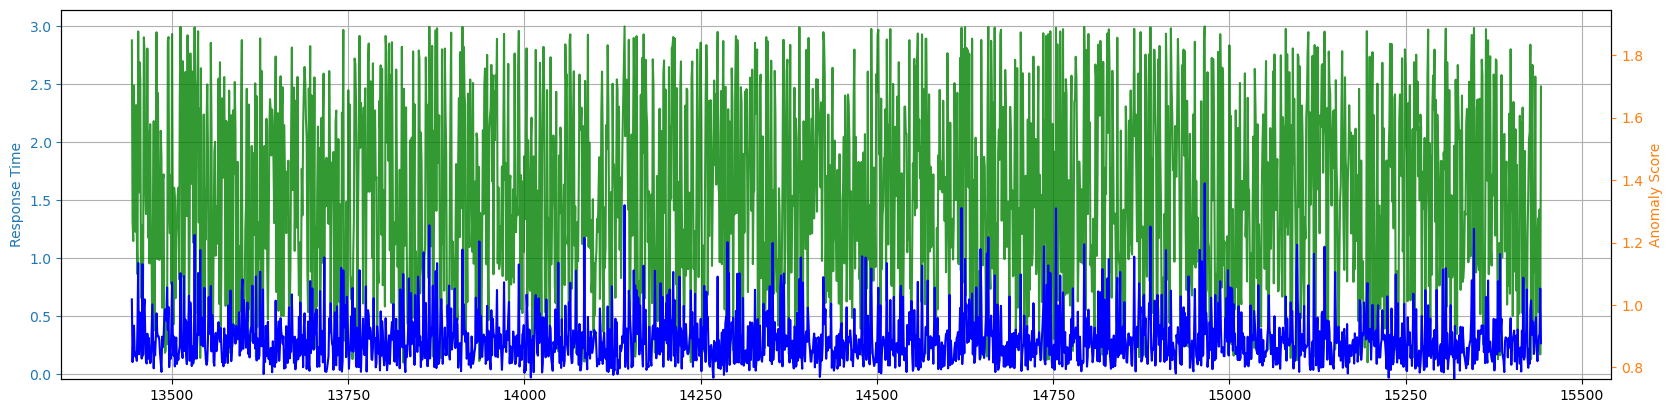

In [60]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

maxNoRecords = 2000
#
# *Try this out* - change `start` and `end` to zoom in on the
# anomaly found earlier in this notebook
#
start, end = 0, len(test_df)
# start, end = 5500, 6500
data_subset = test_df[start:end][:maxNoRecords]

ax1.plot(data_subset["response_time"], color="green", alpha=0.8)
ax2.plot(data_subset["score"], color="blue")

ax1.grid(which="major", axis="both")

ax1.set_ylabel("Response Time", color="C0")
ax2.set_ylabel("Anomaly Score", color="C1")

ax1.tick_params("y", colors="C0")
ax2.tick_params("y", colors="C1")

#ax1.set_ylim(0, 40000)
ax2.set_ylim(min(scores), 1.4 * max(scores))
fig.set_figwidth(20)

In [61]:
test_df["outlier_3sigma"].sum()

52

In [62]:
test_df.head()

,log_identifier,timestamp,log_level,ip_address,user_id,method,path,status_code,response_time,message,score,outlier_3sigma,outlier_2sigma,outlier_1sigma
13443,LOG-003662,1.728623e+09,DEBUG,205.98.134.200,856a40be-cf06-4e2c-be7d-986b7d187088,POST,category,502,2.877,Data field free return.,1.017889,0,0,1
13444,LOG-003663,1.728623e+09,WARN,195.110.250.69,5a274300-a7fb-43f1-9e5d-dccb70d23db2,DELETE,category,401,1.313,Friend financial memory black suffer live need.,0.817281,0,0,0
13445,LOG-003664,1.728623e+09,DEBUG,112.73.81.106,a8ae7a4a-80a5-440f-810e-f4ec7fe3dae4,POST,app/tags/main,502,1.147,Pass side kind represent call.,0.908257,0,0,0
13446,LOG-003665,1.728623e+09,ERROR,213.247.216.240,27c0608f-7450-46f7-b03c-e8c54ea98e03,GET,explore,200,2.487,Hundred I maintain interest whether strong.,0.933890,0,0,0
13447,LOG-003666,1.728623e+09,DEBUG,156.60.57.38,f8f4a55c-ba21-4fb6-a909-8802cb5a366f,GET,tags,400,1.336,Couple media call college space big improve.,0.848353,0,0,0


In [63]:
test_df.columns

Index(['log_identifier', 'timestamp', 'log_level', 'ip_address', 'user_id',
       'method', 'path', 'status_code', 'response_time', 'message', 'score',
       'outlier_3sigma', 'outlier_2sigma', 'outlier_1sigma'],
      dtype='object')

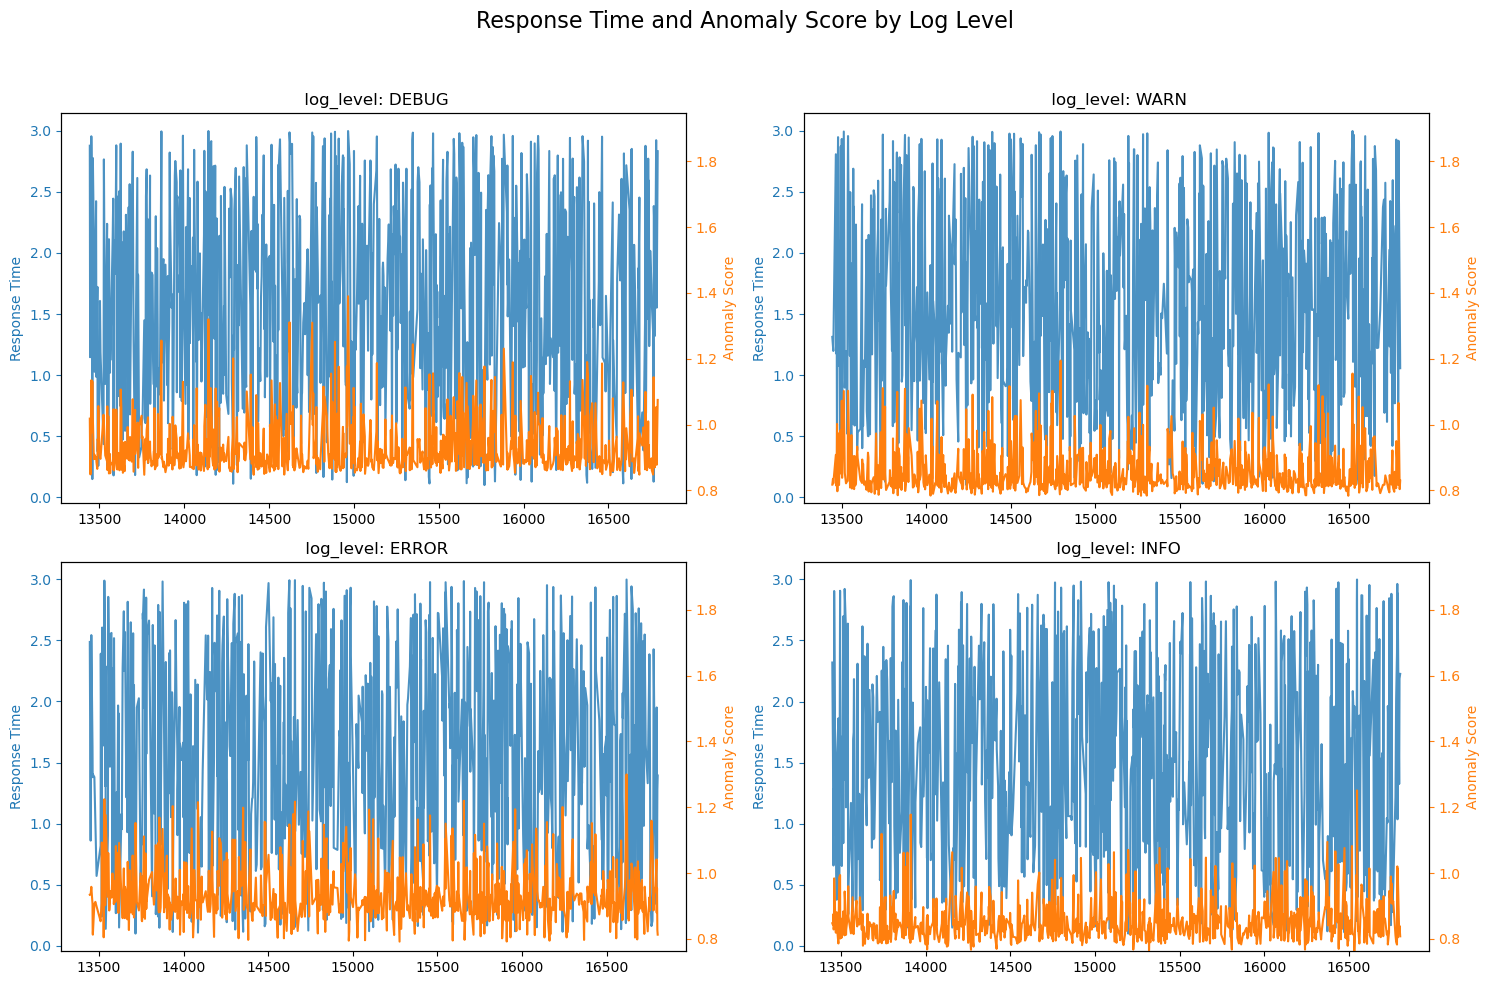

In [64]:
#from vis_functions import vis_response_time_score_foreach

vis_lib.vis_response_time_score_foreach(test_df, 'log_level')

In [65]:
test_df.columns

Index(['log_identifier', 'timestamp', 'log_level', 'ip_address', 'user_id',
       'method', 'path', 'status_code', 'response_time', 'message', 'score',
       'outlier_3sigma', 'outlier_2sigma', 'outlier_1sigma'],
      dtype='object')

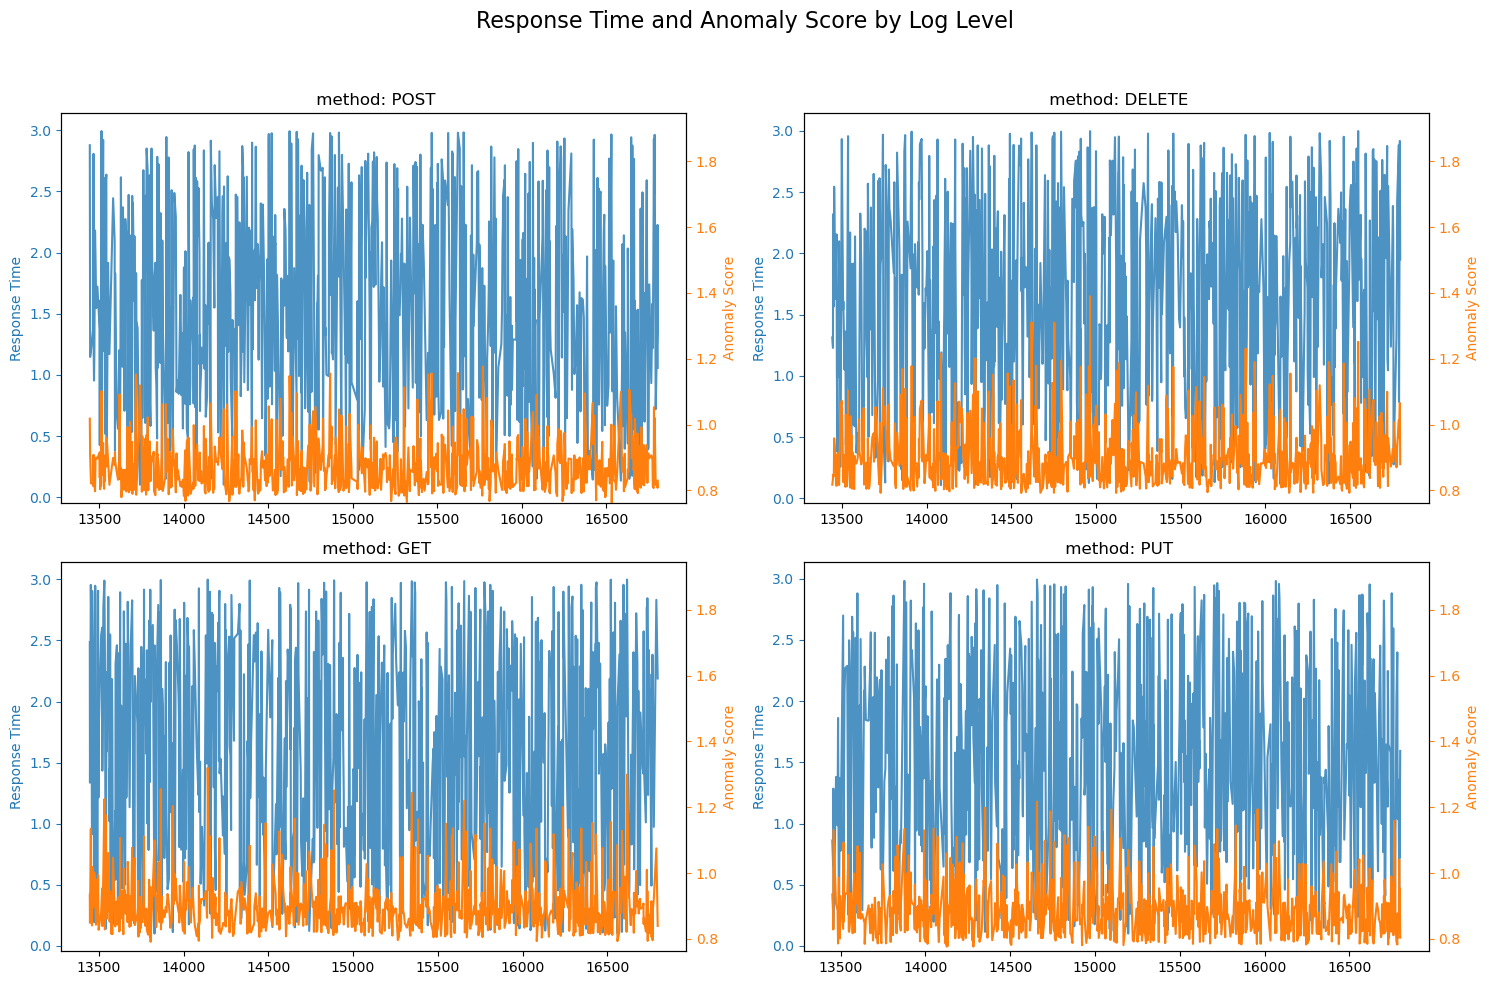

In [66]:
import vis_lib
vis_lib.vis_response_time_score_foreach(test_df, 'method')

In [67]:
test_df.head()

,log_identifier,timestamp,log_level,ip_address,user_id,method,path,status_code,response_time,message,score,outlier_3sigma,outlier_2sigma,outlier_1sigma
13443,LOG-003662,1.728623e+09,DEBUG,205.98.134.200,856a40be-cf06-4e2c-be7d-986b7d187088,POST,category,502,2.877,Data field free return.,1.017889,0,0,1
13444,LOG-003663,1.728623e+09,WARN,195.110.250.69,5a274300-a7fb-43f1-9e5d-dccb70d23db2,DELETE,category,401,1.313,Friend financial memory black suffer live need.,0.817281,0,0,0
13445,LOG-003664,1.728623e+09,DEBUG,112.73.81.106,a8ae7a4a-80a5-440f-810e-f4ec7fe3dae4,POST,app/tags/main,502,1.147,Pass side kind represent call.,0.908257,0,0,0
13446,LOG-003665,1.728623e+09,ERROR,213.247.216.240,27c0608f-7450-46f7-b03c-e8c54ea98e03,GET,explore,200,2.487,Hundred I maintain interest whether strong.,0.933890,0,0,0
13447,LOG-003666,1.728623e+09,DEBUG,156.60.57.38,f8f4a55c-ba21-4fb6-a909-8802cb5a366f,GET,tags,400,1.336,Couple media call college space big improve.,0.848353,0,0,0


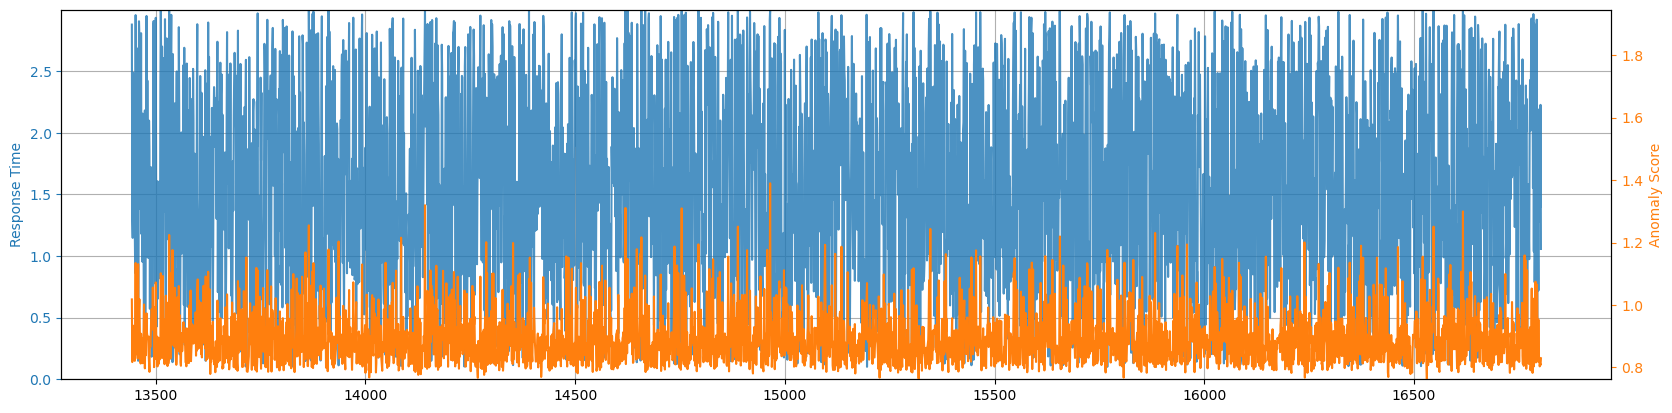

In [73]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

#
# *Try this out* - change `start` and `end` to zoom in on the
# anomaly found earlier in this notebook
#
start, end = 0, len(test_df)
dataset_subset = test_df[start:end]

ax1.plot(dataset_subset["response_time"], color="C0", alpha=0.8)
ax2.plot(dataset_subset["score"], color="C1")

#visualize one of the venues
#ax3.plot(dataset_subset[dataset.Venue == 'XOFF']["TradingTime"], color="C1")

ax1.grid(which="major", axis="both")

ax1.set_ylabel("Response Time", color="C0")
ax2.set_ylabel("Anomaly Score", color="C1")

ax1.tick_params("y", colors="C0")
ax2.tick_params("y", colors="C1")

#ax3.tick_params("y", colors="C3")

ax1.set_ylim(0, max(dataset_subset["response_time"])) # max = 24 hours
ax2.set_ylim(min(scores), 1.4 * max(scores))
fig.set_figwidth(20)


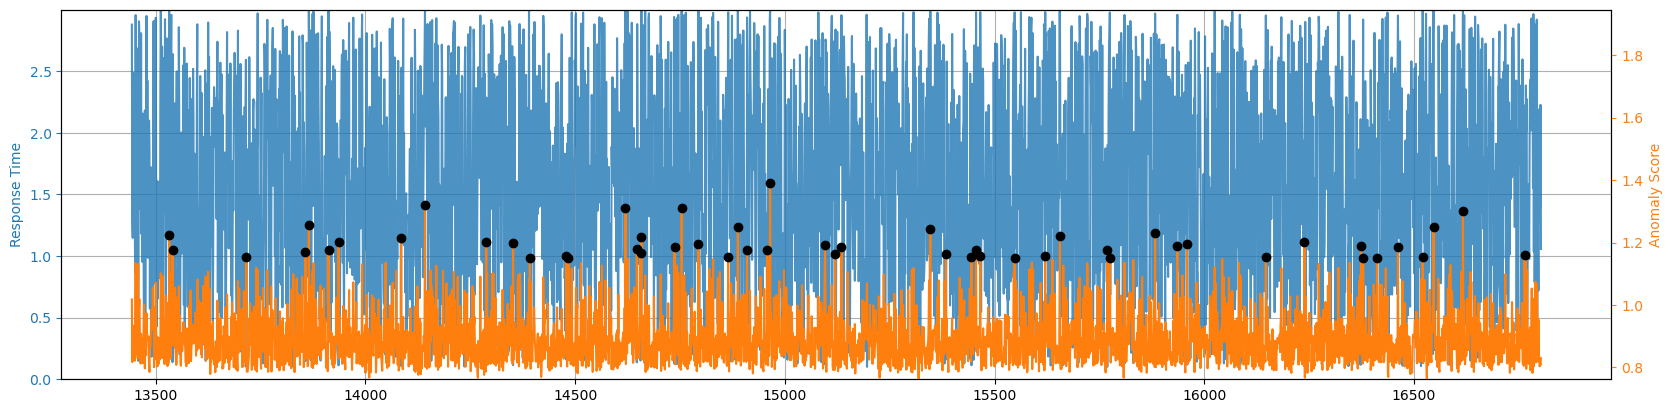

In [74]:
anomalies = test_df[test_df["score"] > threshold3]
ax2.plot(anomalies.index, anomalies.score, "ko")
fig

# Store data with Score in S3

In [70]:
import boto3
import sagemaker 
sess = sagemaker.Session()


#bucket = 'dataset-noora'
test_df.to_csv('gameday_data_with_scores_with_header.csv', index=False, header=True)
data_with_scores_path = sess.upload_data(
    path='gameday_data_with_scores_with_header.csv', 
    bucket=downloaded_data_bucket,#"bsc-gameday-2024"
    key_prefix=downloaded_data_prefix # "dataset" 
)
data_with_scores_path


's3://bsc-gameday-2024/dataset/gameday_data_with_scores_with_header.csv'

<Axes: >

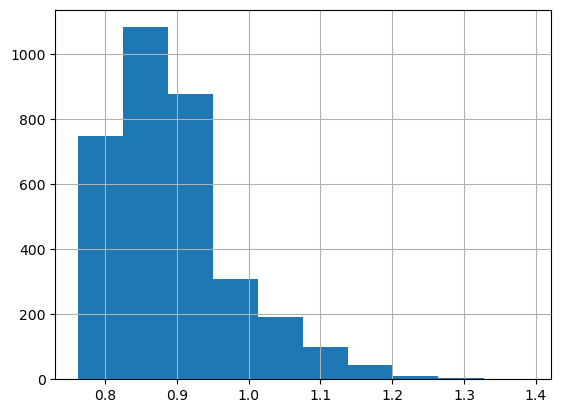

In [71]:
test_df.score.hist()

The score distribution is skewed to the right.
(Right-tailed distribution)

- majority of the values fall within a lower range. meaning that majority of data points have a low anomaly score.
- few data points are extended to the right with high anomaly score.
- concentration of normal data 
- Threshold consideration

# The End